In [1]:
import numpy as np
from ASDShCom_Ripoll import *
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'
plt.rcParams.update({'font.size': 18})

In [2]:
# physical constants
c = 3e8
hbar = 1e-34

readout_rate = lambda tRT, T : -0.5/tRT*np.log(1-T) # tRT: round-trip time, T: transmission

# squeezer parameter standard (high)
xRatio0 = 0.95

# loss standard: T_loss_a, T_loss_b, T_loss_c, Rpd
losses0 = (100e-6, 1000e-6, 1000e-6, 0.1)

# readout standards: phiPump, psi0, psi1, psi2
signalRO = np.pi/2, np.pi/2, np.pi/2, 0 # phiPump and psi1 are arbitrary
idlerRO = np.pi/2, np.pi/2, np.pi/2, np.pi/2 # psi0 is arbitrary

class IFO(object):
    def __init__(self, lambda0, L_arm, L_SRC, P_circ, T_ITM, T_SRM, M, ws=None, gbR=None, gcR=None):
        """
        
        if gbR and gcR specified, then ws must be as well
        """
        # interferometer parameters, see below for L_SRC and T_ITM
        self.lambda0 = lambda0
        self.L_arm = L_arm
        self.P_circ = P_circ
        self.T_SRM = T_SRM
        self.M = M
        
        # derived parameters
        self.w0 = 2*np.pi*c/self.lambda0
        self.B = sqrt(self.P_circ*self.L_arm*self.w0/(hbar*c))
        self.mu = self.M/4
        self.rho = (sqrt(2)*((self.B**2)*((self.L_arm**-2.)*hbar)))/self.mu
        self.tRT_arm = 2*self.L_arm/c

        # optional direct definition of ws, gbR, gcR
        # fixing T_SRM=0.046 and changing T_ITM and L_SRC
        if gbR is None and gcR is None:
            self.L_SRC = L_SRC 
            self.tRT_SRC = 2*self.L_SRC/c
            self.gbR = readout_rate(self.tRT_SRC,self.T_SRM)
            # default to signal-idler symmetric at SRM
            self.gcR = self.gbR
        elif gbR is None:
            # e.g. for setting gcR = 0 (closing idler port)
            self.L_SRC = L_SRC 
            self.tRT_SRC = 2*self.L_SRC/c
            self.gbR = readout_rate(self.tRT_SRC,self.T_SRM)
            self.gcR = gcR
        elif gcR is None:
            # sim. for closing signal port
            self.L_SRC = L_SRC 
            self.tRT_SRC = 2*self.L_SRC/c
            self.gcR = readout_rate(self.tRT_SRC,self.T_SRM)
            self.gbR = gbR
        else: 
            self.gbR = gbR
            self.gcR = gcR
            if self.gbR == 0:
                self.tRT_SRC = -0.5/self.gcR*np.log(1-self.T_SRM)
            else:
                self.tRT_SRC = -0.5/self.gbR*np.log(1-self.T_SRM)
            # if both specified, then L_SRC is inferred from T_SRM
            self.L_SRC = c*self.tRT_SRC/2

        if ws is not None: 
            self.ws = ws
            self.T_ITM = (2*self.ws/c)**2*self.L_arm*self.L_SRC # Titm inferred from ws
        else:
            self.T_ITM = T_ITM
            self.ws = 0.5*(c*(sqrt(((self.T_ITM/self.L_SRC)/self.L_arm))))            

    def print_params(self):
        """Titm and Lsrc will be inferred from ws, gbR, gcR if the latter are specified"""
        print("""lambda0={:.3e}m, L_arm={:.1f}km, L_SRC={:.1f}m, P_circ={:.1e}W, T_ITM={:.3f}, T_SRM={:.3f}, M={}kg,
ws/(2pi)={:.3f}kHz, gbR/(2pi)={:.3f}kHz, gcR/(2pi)={:.3f}kHz""".format(
            self.lambda0, self.L_arm*1e-3, self.L_SRC, self.P_circ, self.T_ITM, self.T_SRM, self.M,
              self.ws/(2*np.pi)*1e-3, self.gbR/(2*np.pi)*1e-3, self.gcR/(2*np.pi)*1e-3))

    def ga_fn(self, T_loss_a): return readout_rate(self.tRT_arm,T_loss_a)
    def gbtot_fn(self, T_loss_b): return self.gbR + readout_rate(self.tRT_SRC,T_loss_b)
    def gctot_fn(self, T_loss_c): return self.gcR + readout_rate(self.tRT_SRC,T_loss_c)
        
    def singularity_thr(self, T_loss_a, T_loss_b, T_loss_c):
        # ((W0, x0), (W1, x1))
        ga = self.ga_fn(T_loss_a)
        gbtot = self.gbtot_fn(T_loss_b)
        gctot = self.gctot_fn(T_loss_c)

        # poleSol = np.array([[0,sqrt((gctot*(gbtot+((self.ws**2)/ga))))],[sqrt(((((gctot*(self.ws**2))-(ga*(self.ws**2)))-((ga**2)*(gbtot+gctot)))/(gbtot+\gctot))),sqrt(((ga+gbtot)*(ga+(gctot+((self.ws**2)/(gbtot+gctot))))))]])
        if T_loss_a != 0:
            thr = min(sqrt((gctot*(gbtot+((self.ws**2)/ga)))),
                      sqrt(((ga+gbtot)*(ga+(gctot+((self.ws**2)/(gbtot+gctot)))))))
        else: 
            thr = sqrt(((ga+gbtot)*(ga+(gctot+((self.ws**2)/(gbtot+gctot))))))
        return thr
    
    def ASDSh(self, f, xRatio, T_loss_a, T_loss_b, T_loss_c, Rpd, phiPump, psi0, psi1, psi2, radiation_pressure_on=True):
        """combined readout with full freedom, ASD of NSR, using fn from mathematica"""
        ga = self.ga_fn(T_loss_a)
        gbtot = self.gbtot_fn(T_loss_b)
        gctot = self.gctot_fn(T_loss_c)
        x = xRatio*self.singularity_thr(T_loss_a, T_loss_b, T_loss_c)
        
        if radiation_pressure_on:
            rho = self.rho
        else:
            rho = 0
        
        NSR = ASDShCom(2*np.pi*f, self.B, self.ws, x, ga, gbtot, self.gbR, gctot, self.gcR, phiPump, psi0, psi1, psi2, rho, Rpd)
        if NSR.imag > 1e-30:
            raise ValueError("significant imaginary component")
        else:
            return NSR.real

In [3]:
# IFO(lambda0, L_arm, L_SRC, P_circ, T_ITM, T_SRM, M, ws=None, gbR=None, gcR=None)
# aLIGO = IFO(1064e-9, 4e3, 56, 750e3, 0.014, 0.325, 40, None, None, 0)
# aLIGO.print_params()

liIFO = IFO(2e-6, 4e3, None, 3e6, None, 0.046, 200, 2*np.pi*5000, 2*np.pi*500, 0)
liIFO.print_params()

# plotting
f_List = np.logspace(0,5,num=100) # between 10^a and 10^b

def fn0(f):
    return liIFO.ASDSh(f,0,0,0,0,0,0,np.pi/2,0,0)

def fn1(f):
    return liIFO.ASDSh(f,0.95,0,0,0,0,0,np.pi/2,0,0)

def fn2(f):
    return liIFO.ASDSh(f,1,0,0,0,0,0,np.pi/2,0,0)

lambda0=2.000e-06m, L_arm=4.0km, L_SRC=1124.2m, P_circ=3.0e+06W, T_ITM=0.197, T_SRM=0.046, M=200kg,
ws/(2pi)=5.000kHz, gbR/(2pi)=0.500kHz, gcR/(2pi)=0.000kHz


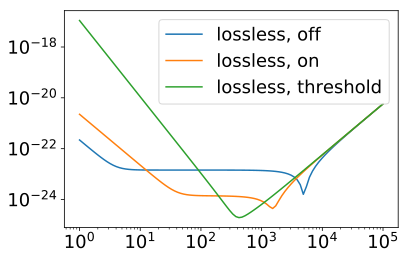

In [4]:
# parallel plotting
from multiprocessing import Pool
pool = Pool()
lossless_off = pool.map(fn0, f_List)
lossless_on = pool.map(fn1, f_List)
lossless_thr = pool.map(fn2, f_List)

plt.rcParams.update({'font.size': 18})

fig, ax = plt.subplots(figsize=(6,4))
ax.loglog(f_List, lossless_off, label='lossless, off')
ax.loglog(f_List, lossless_on, label='lossless, on')
ax.loglog(f_List, lossless_thr, label='lossless, threshold')
ax.legend()
plt.show()

In [5]:
# recover signal and idler comparison
ifo = IFO(2e-6, 4e3, None, 3e6, None, 0.046, 200, 2*np.pi*5000, 2*np.pi*500, 2*np.pi*5)
# ifo.print_params()

# plotting
f_List = np.logspace(np.log10(5e0),np.log10(2e4),num=100) # between 10^a and 10^b

def fn0(f):
    return ifo.ASDSh(f,xRatio0,*losses0,*signalRO) # cannot pickle lambdas

def fn1(f):
    return ifo.ASDSh(f,xRatio0,*losses0,*idlerRO)

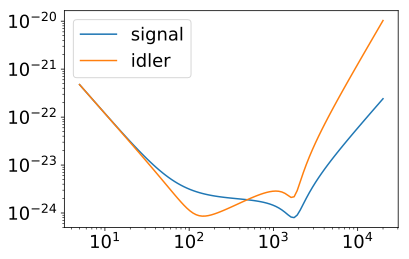

In [6]:
# parallel plotting
from multiprocessing import Pool
pool = Pool()
res0_signal = pool.map(fn0, f_List)
res1_idler = pool.map(fn1, f_List)

fig, ax = plt.subplots(figsize=(6,4))
ax.loglog(f_List, res0_signal, label='signal')
ax.loglog(f_List, res1_idler, label='idler')
ax.legend()
plt.show()

In [7]:
# recovering idler variational readout
ifo = IFO(2e-6, 4e3, None, 3e6, None, 0.046, 200, 2*np.pi*5000, 0, 2*np.pi*500)

phiPump_List = np.array([1,2,4,6,7])*np.pi/8

# plotting
f_List = np.logspace(np.log10(1),np.log10(1e4),num=100) # between 10^a and 10^b

def fn0(tupl):
    f, phiPump = tupl
    return ifo.ASDSh(f,xRatio0,*losses0,phiPump,np.pi/2,np.pi/2,np.pi/2)

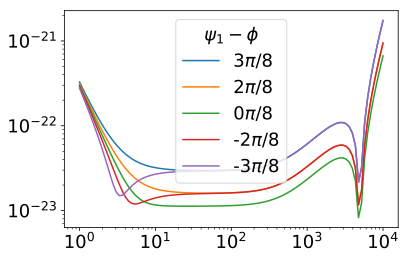

In [8]:
# parallel plotting
from multiprocessing import Pool
pool = Pool()
res0_List = np.array([pool.map(fn0, ((f, phiPump_List[i]) for f in f_List)) for i in range(len(phiPump_List))])

fig, ax = plt.subplots(figsize=(6,4))
for i, phi in enumerate(phiPump_List):
    ax.loglog(f_List, res0_List[i], label='{:g}$\pi/8$'.format((np.pi/2-phi)*8/np.pi))
ax.legend(title='$\psi_1-\phi$')
plt.show()

In [9]:
# coherently combined signal and idler
ifo = IFO(2e-6, 4e3, None, 3e6, None, 0.046, 200, 2*np.pi*5000, 2*np.pi*500, 2*np.pi*5)

f_List = np.logspace(np.log10(5e0),np.log10(2e4),num=100)

def fn0(f):
    # signal mode in 2nd quad, idler mode in coh. comb. quad with squeezed QRPN, equal comb. s-i
    return ifo.ASDSh(f,xRatio0,*losses0,np.pi/2,np.pi/2,np.pi/2-np.pi*3/8,np.pi/4)

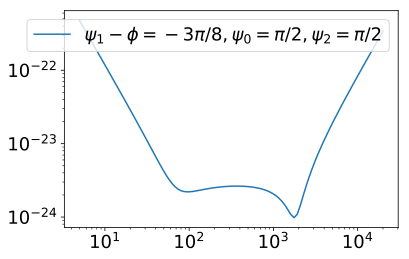

In [10]:
from multiprocessing import Pool
pool = Pool()
res0 = pool.map(fn0, f_List)

fig, ax = plt.subplots(figsize=(6,4))
ax.loglog(f_List, res0, label='$\psi_1-\phi=-3\pi/8, \psi_0=\pi/2, \psi_2=\pi/2$')
ax.legend()
plt.show()

In [ ]:
# to-do: write function to parallelise automatically, create simple plotting method (then add parallelization?)